In [43]:
import numpy as np
import pandas as pd
import pickle
import sklearn
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import datasets
from feature_extraction import get_names
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from pag import pag


#from random_sampling import random_sampling
#from random_mix import ramdom_mix

In [10]:
def random_mix(X):
    N,_ = X.shape
    idx = np.random.permutation(N)
    X_ans = []
    for i in idx:
        X_ans.append(X[i])
    
    return np.array(X_ans)

In [11]:
import numpy as np


def random_sampling(X, dist = 'Uniform', size = 0.7):
    '''
    Parameters:
    X -> the data of N rows and m columns
    dist -> a string with the desired distribution of the sampling ['Uniform', 'Triangular', 'Geometric']
    size -> the percentage of X to be chosen

    Output:
    A random sample containing the size*100% of the data of X
    '''

    N,_ = X.shape
    n_samples = int(size* N)
    indexes = [i for i in range(N)]
    samples = []
    p = []
    sum_p = 0
    if dist == 'Triangular':
        a,b,c = 0, N/2, N
        for i in range(N):
            if i <= b:
                p.append((2*(i-a))/((b-a)*(c-a)))
            else:
                p.append((2*(c-i))/((c-a)*(c-b)))
            sum_p += p[i-1]
    
    if dist == 'Geometric':
        for i in range(N):
            p.append(0.5*((1-0.5)**i))
    if dist == 'Uniform':
        samples = np.random.choice(indexes, size = n_samples)

    elif dist == 'Triangular':
        samples = np.random.choice(indexes, p = p, size = n_samples, replace = False)

    elif dist == 'Geometric':
        samples = np.random.choice(indexes, p = p, size = n_samples, replace = False)
    
    not_samples = []
    for i in indexes:
        if(i in samples):
            continue
        not_samples.append(i)
        
    return X[np.ix_(samples)], X[np.ix_(not_samples)]


In [453]:
def get_train_test(suggested, X, y):
  # Sampling
  X_mixed = random_mix(np.append(X,y.reshape(y.shape[0],1), axis = 1))
  X_mixed.shape
  X_train, X_test = random_sampling(X_mixed, size = suggested/200)
  X_train, y_train =  X_train[:,:-1], X_train[:,-1]
  X_test, y_test =  X_test[:,:-1], X_test[:,-1]
  assert X_train.shape[0] == y_train.shape[0]
  assert X_test.shape[0] == y_test.shape[0]
  print("Number of registers per class on the training set: ")
  print(pd.Series(y_train).value_counts())
  return X_train, y_train, X_test, y_test
  

# Load data

In [13]:
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

In [14]:
# Read musical features
infile = open('dataset_features.pckl','rb')
features = pickle.load(infile)
infile.close()

In [15]:
names = get_names()
names.append("Label")
df = pd.DataFrame(features, columns = names)
list_cols = []
for coll in df.columns:
  col = str(coll)
  if(col.find("pitch") > 0 and (col.find("min") > 0 or col.find("max") > 0)): 
    continue
  if(col in ["tempogram_min", "tempogram_max"]):
    continue
  list_cols.append(col)
print(len(list_cols))
df_songs = df[list_cols]
df_songs.head()

119


,1_pitch_mean,1_pitch_std,2_pitch_mean,2_pitch_std,3_pitch_mean,3_pitch_std,4_pitch_mean,4_pitch_std,5_pitch_mean,5_pitch_std,...,18_mfcc_std,19_mfcc_min,19_mfcc_max,19_mfcc_mean,19_mfcc_std,20_mfcc_min,20_mfcc_max,20_mfcc_mean,20_mfcc_std,Label
0,0.367158,0.250658,0.446059,0.303279,0.345249,0.267387,0.378227,0.330485,0.358498,0.265262,...,6.322423,-35.063286,22.445841,-6.158485,7.843939,-15.309130,32.983795,5.411145,6.995747,0.0
1,0.548021,0.321238,0.505586,0.274560,0.521004,0.300331,0.554739,0.276167,0.581093,0.289333,...,7.282372,-24.618061,21.180487,-0.404446,5.324600,-18.628052,39.097198,3.593739,5.749859,0.0
2,0.228689,0.281790,0.141832,0.164917,0.200010,0.270996,0.226451,0.255719,0.352861,0.332630,...,7.605660,-29.139126,22.793182,-1.253622,7.343888,-26.660023,21.146843,-0.899938,6.930117,0.0
3,0.341178,0.246983,0.478602,0.343246,0.281382,0.211076,0.306389,0.270918,0.313350,0.240436,...,5.671211,-28.038145,19.897411,-5.406955,5.860555,-18.276693,26.443262,1.132697,6.015408,0.0
4,0.227324,0.213584,0.520437,0.396417,0.204974,0.203153,0.249976,0.289113,0.297624,0.357263,...,7.713253,-32.549755,21.090767,-4.515356,8.532988,-27.717663,29.424013,-4.685843,8.793524,0.0


# Learning Considerations

In [57]:
def compute_pags(num_features, depth_tree):
  epsilons = [0.1, 0.2, 0.3]
  deltas = [0.1, 0.2, 0.3]
  models = ["Logistic Regression",  "Decision Tree", "SVM linear", "SVM polynomial", "SVM rbf"]
  n_results = []
  for delta,epsilon in zip(deltas,epsilons):
    ns = ['('+str(delta)+','+str(epsilon)+')']
    for model in models:
      ns.append(pag(epsilon = epsilon, delta = delta, model = model,  num_features = num_features, depth_tree = depth_tree))
    n_results.append(ns)
  df_pags = pd.DataFrame(n_results)
  df_pags.columns = ["delta/epsilon","Logistic Regression",  "Decision Tree", "SVM linear", "SVM polynomial", "SVM rbf"]
  return df_pags

In [51]:
compute_pags(118,3)

,delta/epsilon,Logistic Regression,Decision Tree,SVM linear,SVM polynomial,SVM rbf
0,"(0.1,0.1)",47.004804,1162.965173,46.051702,40.943446,inf
1,"(0.2,0.2)",20.036666,284.735631,19.560115,17.005987,inf
2,"(0.3,0.3)",12.006227,124.987797,11.688526,9.985774,inf


In [89]:
df_pags = pd.DataFrame(n_results)
df_pags.columns = ["delta/epsilon","Logistic Regression",  "Decision Tree", "SVM linear", "SVM polynomial", "SVM rbf"]
df_pags.head()

,delta/epsilon,Logistic Regression,Decision Tree,SVM linear,SVM polynomial,SVM rbf
0,"(0.1,0.1)",70.817086,2026.800009,70.732697,40.943446,inf
1,"(0.2,0.2)",31.942807,500.694340,31.900613,17.005987,inf
2,"(0.3,0.3)",19.943654,220.969445,19.915525,9.985774,inf


# Visualization

In [147]:
# Codigo para plotear de Pablo Osorio
def plot_3d(data, x_name, y_name, z_name):
  return  px.scatter_3d(df, x=x_name, y=y_name, z=z_name,
              color='Label')
data = df_songs[[ "spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std", "Label"]]
#plot_3d(data, "spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std")

In [136]:
def plot(df,x_name, y_name, z_name, label, title):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')

    df1 = df[df['Label']==0]
    df2 = df[df['Label']==1]
    ax.scatter3D(
        df1[x_name],
        df1[y_name],
        df1[z_name],
        color = 'hotpink',
        label = 'Like'
    )
    ax.scatter3D(
        df2[x_name],
        df2[y_name],
        df2[z_name],
        color = 'teal',
        label = 'Dislike'
    )
    ax.legend(loc=1)
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(x_name, fontsize = 15)
    ax.set_ylabel(y_name, fontsize = 15)
    ax.set_zlabel(z_name, fontsize = 15)
    ax.legend

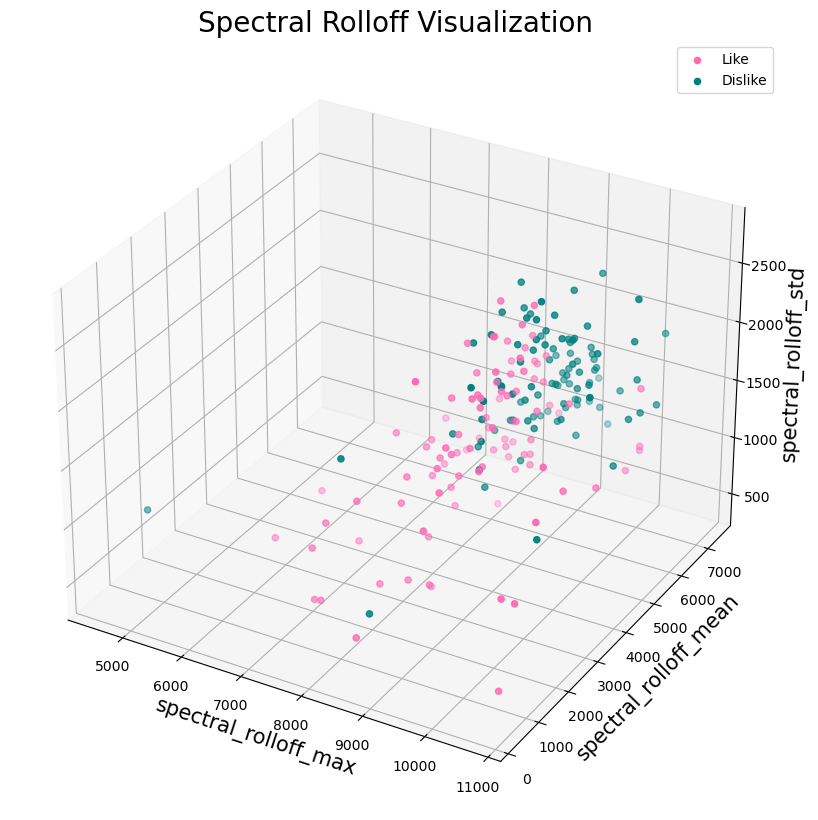

In [186]:
data = df_songs[["spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std", 'Label']]
plot(data,"spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std", "Label", "Spectral Rolloff Visualization")

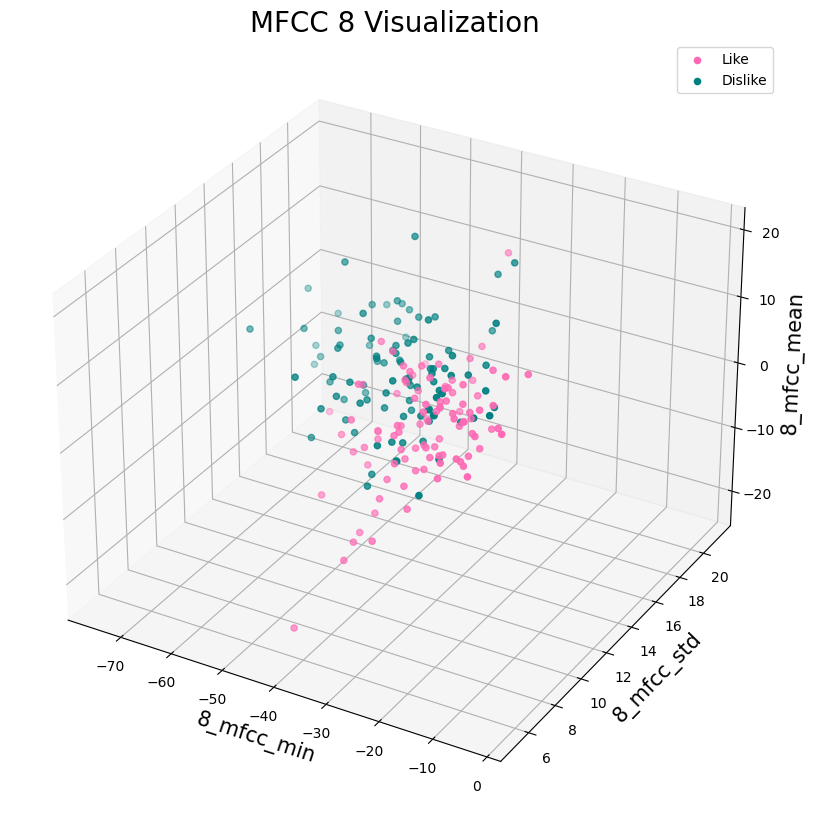

In [146]:
i = 8
x_name = str(i)+"_mfcc_min"
y_name = str(i)+"_mfcc_std"
z_name = str(i)+"_mfcc_mean"
data = df_songs[[x_name, y_name , z_name, 'Label']]
plot(data, x_name, y_name,z_name, "Label", "MFCC "+ str(i)+" Visualization")

In [166]:
def plot2d(df,x_name, y_name, label, title):
    fig, ax = plt.subplots()

    df1 = df[df['Label']==0]
    df2 = df[df['Label']==1]
    ax.scatter(
        df1[x_name],
        df1[y_name],
        c = 'hotpink',
        label = 'Like'
    )
    ax.scatter(
        df2[x_name],
        df2[y_name],
        c = 'teal',
        label = 'Dislike'
    )
    plt.legend(loc=1)
    plt.title(title, fontsize = 10)
    ax.set_xlabel(x_name, fontsize = 8)
    ax.set_ylabel(y_name, fontsize = 8)

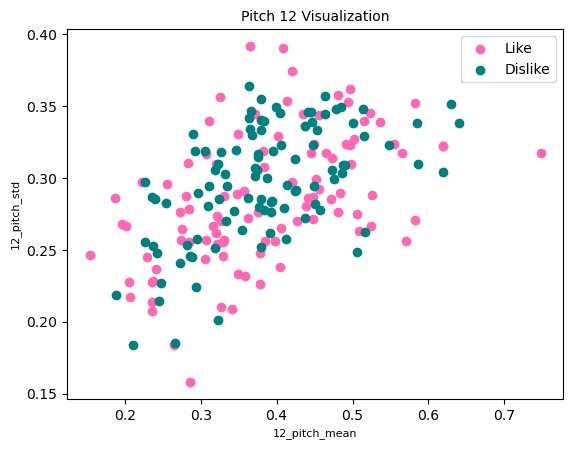

In [178]:
i = 12
x_name = str(i)+"_pitch_mean"
y_name = str(i)+"_pitch_std"
data = df_songs[[x_name, y_name, 'Label']]
plot2d(data, x_name, y_name, "Label", "Pitch "+ str(i)+" Visualization")

In [184]:
df["tempogram_std"].value_counts()

0.0    201
Name: tempogram_std, dtype: int64

# Supervised Learning with Iris

In [40]:
def compute_errors(model, X_train, y_train, X_test, y_test):
  for class_ in np.unique(y_train):
    training_error = compute_error(model.predict(X_train), y_train, class_ = class_)
    print(f'The training error for Class {class_} is: {training_error}')
  for class_ in np.unique(y_test):
    generalization_error = compute_error(model.predict(X_test), y_test, class_ = class_)
    print(f'The generalization error for Class {class_} is: {generalization_error}')

In [33]:
def compute_error(prediction, labels, class_):
  sum = 0
  for i,label in enumerate(labels):
    if label == class_ and prediction[i] != label:
      sum += 1
  return sum/len(labels)

In [25]:
X_mixed = random_mix(np.append(X_iris,y_iris.reshape(y_iris.shape[0],1), axis = 1))
X_mixed.shape
X_train, X_test = random_sampling(X_mixed, size = 0.7)
X_train, y_train =  X_train[:,:-1], X_train[:,-1]
X_test, y_test =  X_test[:,:-1], X_test[:,-1]
print(X_train.shape,y_train.shape,  X_test.shape, y_test.shape)

(105, 4) (105,) (72, 4) (72,)


### Logistic Regression

In [27]:
logistic = LogisticRegression(max_iter = 100000)
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

In [41]:
compute_errors(logistic, X_train, y_train, X_test, y_test)

The training error for Class 0.0 is: 0.0
The training error for Class 1.0 is: 0.0
The training error for Class 2.0 is: 0.01904761904761905
The generalization error for Class 0.0 is: 0.0
The generalization error for Class 1.0 is: 0.013888888888888888
The generalization error for Class 2.0 is: 0.05555555555555555


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


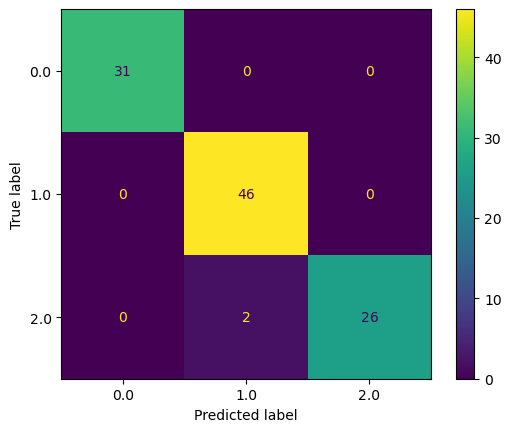

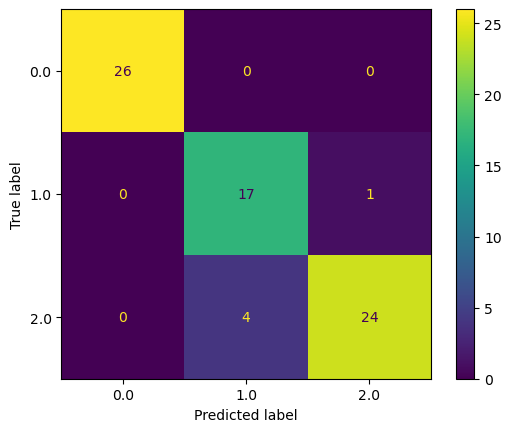

In [42]:
plot_confusion_matrix(logistic,X_train,y_train)
plot_confusion_matrix(logistic,X_test,y_test)

### Decision Tree

In [44]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

The training error for Class 0.0 is: 0.0
The training error for Class 1.0 is: 0.0
The training error for Class 2.0 is: 0.0
The generalization error for Class 0.0 is: 0.0
The generalization error for Class 1.0 is: 0.013888888888888888
The generalization error for Class 2.0 is: 0.041666666666666664


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


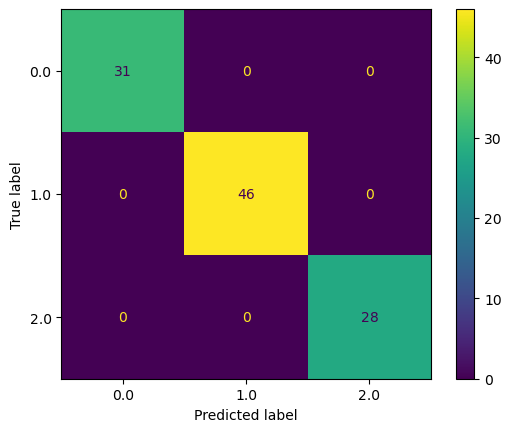

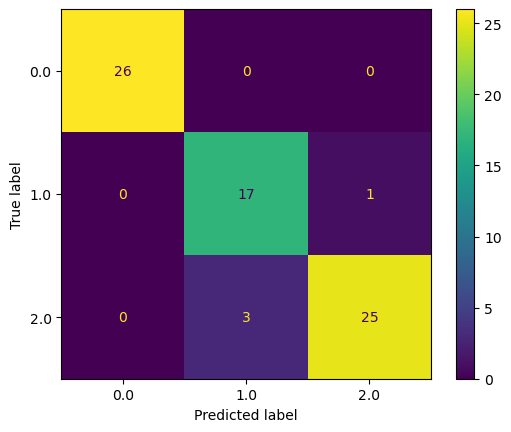

In [45]:
compute_errors(tree, X_train, y_train, X_test, y_test)
plot_confusion_matrix(tree,X_train,y_train)
plot_confusion_matrix(tree,X_test,y_test)

### SVM (linear kernel)

The training error for Class 0.0 is: 0.0
The training error for Class 1.0 is: 0.02857142857142857
The training error for Class 2.0 is: 0.0
The generalization error for Class 0.0 is: 0.0
The generalization error for Class 1.0 is: 0.013888888888888888
The generalization error for Class 2.0 is: 0.041666666666666664


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


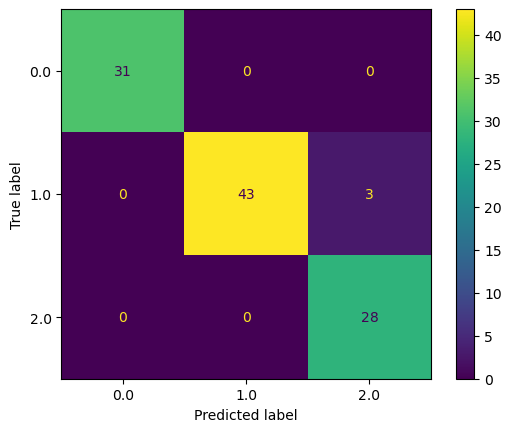

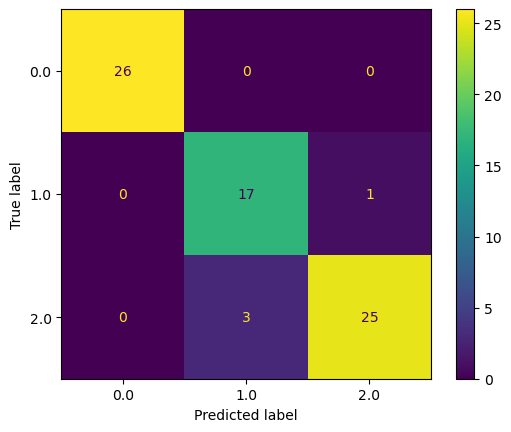

In [46]:
linear_kernel_svm_clf = SVC(kernel = "linear")
compute_errors(linear_kernel_svm_clf.fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(linear_kernel_svm_clf,X_train,y_train)
plot_confusion_matrix(linear_kernel_svm_clf,X_test,y_test)

### SVM (polynomial kernel)

The training error for Class 0.0 is: 0.0
The training error for Class 1.0 is: 0.01904761904761905
The training error for Class 2.0 is: 0.0
The generalization error for Class 0.0 is: 0.0
The generalization error for Class 1.0 is: 0.013888888888888888
The generalization error for Class 2.0 is: 0.041666666666666664


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


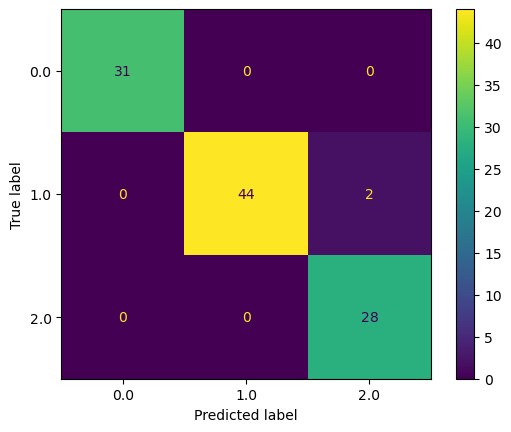

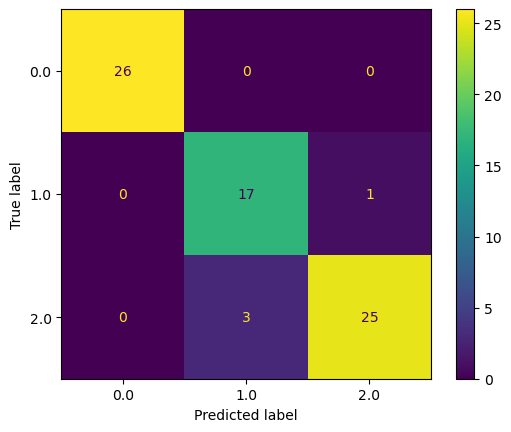

In [49]:
poly_kernel_svm_clf = SVC(kernel = "poly", degree=2)
compute_errors(poly_kernel_svm_clf .fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(poly_kernel_svm_clf ,X_train,y_train)
plot_confusion_matrix(poly_kernel_svm_clf ,X_test,y_test)

### SVM (rbf kernel)

The training error for Class 0.0 is: 0.0
The training error for Class 1.0 is: 0.0
The training error for Class 2.0 is: 0.0380952380952381
The generalization error for Class 0.0 is: 0.0
The generalization error for Class 1.0 is: 0.0
The generalization error for Class 2.0 is: 0.05555555555555555


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


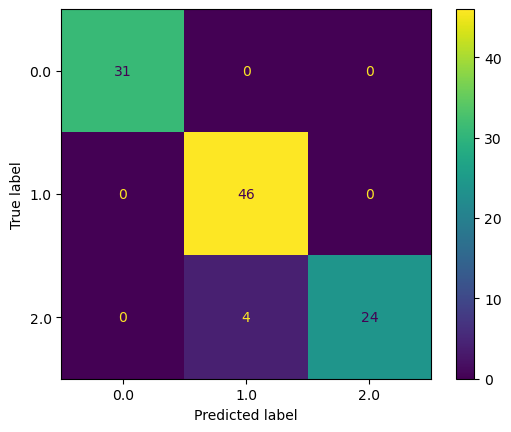

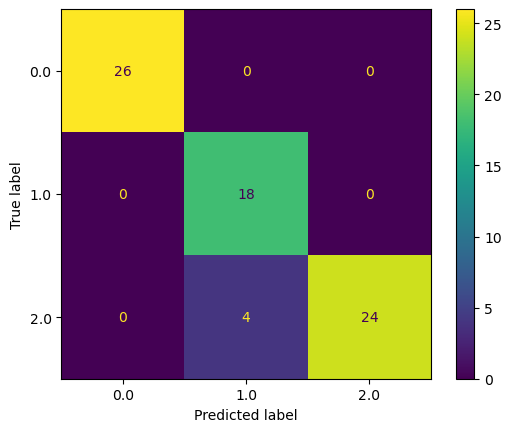

In [47]:
rbf_kernel_svm_clf = SVC(kernel = "rbf")
compute_errors(rbf_kernel_svm_clf.fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(rbf_kernel_svm_clf,X_train,y_train)
plot_confusion_matrix(rbf_kernel_svm_clf,X_test,y_test)

# Supervised Learning with pitch

In [52]:
# Pitch features are 24
compute_pags(24,3)

,delta/epsilon,Logistic Regression,Decision Tree,SVM linear,SVM polynomial,SVM rbf
0,"(0.1,0.1)",47.004804,1162.965173,46.051702,40.943446,inf
1,"(0.2,0.2)",20.036666,284.735631,19.560115,17.005987,inf
2,"(0.3,0.3)",12.006227,124.987797,11.688526,9.985774,inf


In [193]:
list_cols = []
for coll in df.columns:
  col = str(coll)
  if(col.find("pitch") > 0 and (col.find("min") < 0) and (col.find("max") < 0)):
    list_cols.append(col)
print(len(list_cols))
X_songs = df[list_cols].to_numpy()
y_songs = df['Label'].to_numpy()

24


In [421]:
X_train, y_train, X_test, y_test = get_train_test(160, X_songs, y_songs)

Number of registers per class on the training set: 


0.0    83
1.0    77
dtype: int64

The training error for Class 0.0 is: 0.1
The training error for Class 1.0 is: 0.04375
The generalization error for Class 0.0 is: 0.13095238095238096
The generalization error for Class 1.0 is: 0.15476190476190477


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


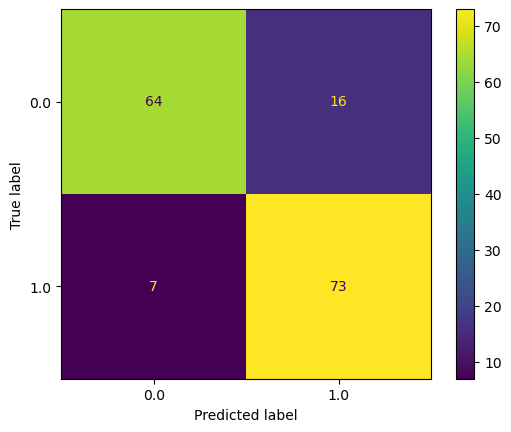

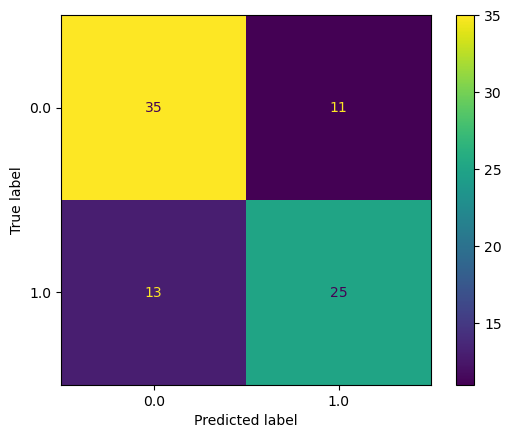

In [219]:
#model = SVC(kernel = "linear")
#model = SVC(kernel = "poly", degree=2)
model = SVC(kernel = "rbf")
#model = DecisionTreeClassifier(max_depth=3)
#model = LogisticRegression(max_iter = 100000)
compute_errors(model.fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(model,X_train,y_train)
plot_confusion_matrix(model,X_test,y_test)

# Supervised learning with dynamics

In [60]:
# Dynamics features are 12
compute_pags(12, 3)

,delta/epsilon,Logistic Regression,Decision Tree,SVM linear,SVM polynomial,SVM rbf
0,"(0.1,0.1)",66.970342,1890.769713,66.846117,40.943446,inf
1,"(0.2,0.2)",30.019435,466.686765,29.957323,17.005987,inf
2,"(0.3,0.3)",18.661407,205.854968,18.619998,9.985774,inf


In [220]:
list_cols = ["spectral_centroid_min", "spectral_centroid_max", "spectral_centroid_mean", "spectral_centroid_std", "zero_crossing_rate_min", "zero_crossing_rate_max", "zero_crossing_rate_mean", "zero_crossing_rate_std", "spectral_rolloff_min", "spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std"]
X_songs = df[list_cols].to_numpy()
y_songs = df['Label'].to_numpy()

In [415]:
X_train, y_train, X_test, y_test = get_train_test(160, X_songs, y_songs)

(160, 12) (160,) (87, 12) (87,)
Number of registers per class on the training set: 


0.0    80
1.0    80
dtype: int64

The training error for Class 0.0 is: 0.14375
The training error for Class 1.0 is: 0.10625
The generalization error for Class 0.0 is: 0.1724137931034483
The generalization error for Class 1.0 is: 0.05747126436781609


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


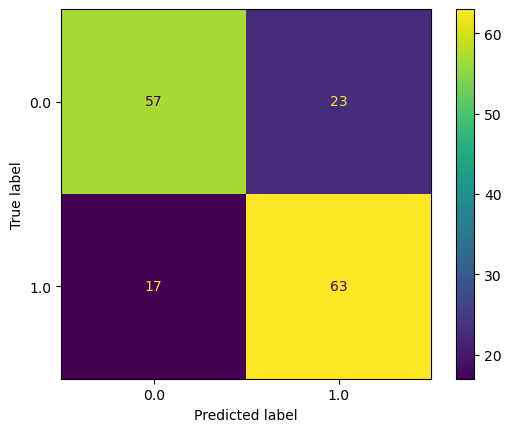

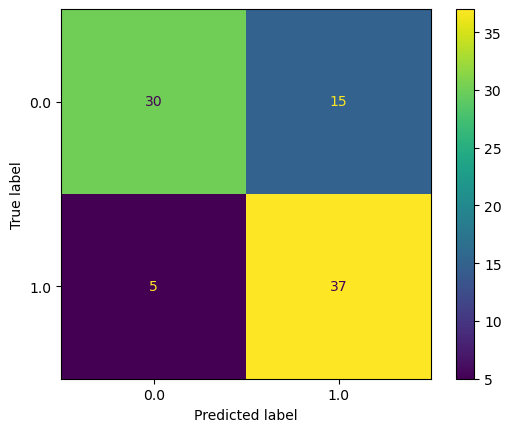

In [416]:
#model = SVC(kernel = "linear")
#model = SVC(kernel = "poly", degree=2)
#model = LogisticRegression(max_iter = 100000)
model = SVC(kernel = "rbf")
compute_errors(model.fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(model,X_train,y_train)
plot_confusion_matrix(model,X_test,y_test)

# Supervised learning with timbre

In [424]:
compute_pags(80,3)

,delta/epsilon,Logistic Regression,Decision Tree,SVM linear,SVM polynomial,SVM rbf
0,"(0.1,0.1)",66.970342,1890.769713,66.846117,40.943446,inf
1,"(0.2,0.2)",30.019435,466.686765,29.957323,17.005987,inf
2,"(0.3,0.3)",18.661407,205.854968,18.619998,9.985774,inf


In [417]:
list_cols = []
for coll in df.columns:
  col = str(coll)
  if(col.find("mfcc") > 0 ):
    list_cols.append(col)
print(len(list_cols))
X_songs = df[list_cols].to_numpy()
y_songs = df['Label'].to_numpy()

80


In [640]:
X_train, y_train, X_test, y_test = get_train_test(160, X_songs, y_songs)

Number of registers per class on the training set: 
0.0    80
1.0    80
dtype: int64


The training error for Class 0.0 is: 0.05625
The training error for Class 1.0 is: 0.13125
The generalization error for Class 0.0 is: 0.05555555555555555
The generalization error for Class 1.0 is: 0.1


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


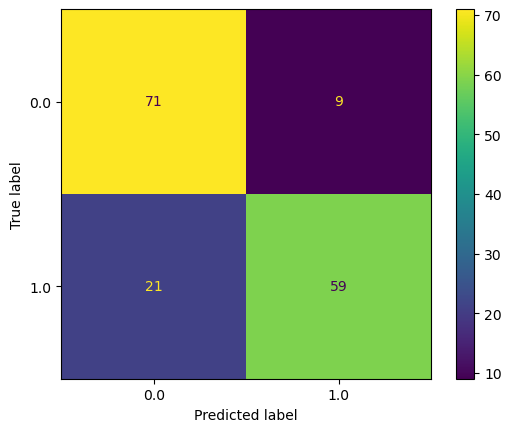

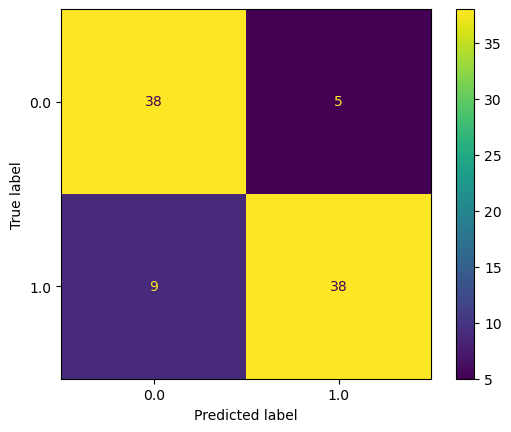

In [641]:
#model = SVC(kernel = "linear")
#model = SVC(kernel = "poly", degree=2)
#model = LogisticRegression(max_iter = 100000)
model = SVC(kernel = "rbf")
compute_errors(model.fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(model,X_train,y_train)
plot_confusion_matrix(model,X_test,y_test)

# Supervised Learning with all features

In [642]:
compute_pags(116,3)

,delta/epsilon,Logistic Regression,Decision Tree,SVM linear,SVM polynomial,SVM rbf
0,"(0.1,0.1)",70.647590,2020.816957,70.561753,40.943446,inf
1,"(0.2,0.2)",31.858059,499.198577,31.815141,17.005987,inf
2,"(0.3,0.3)",19.887156,220.304662,19.858543,9.985774,inf


In [643]:
list_cols = ["spectral_centroid_min", "spectral_centroid_max", "spectral_centroid_mean", "spectral_centroid_std", "zero_crossing_rate_min", "zero_crossing_rate_max", "zero_crossing_rate_mean", "zero_crossing_rate_std", "spectral_rolloff_min", "spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std"]
for coll in df.columns:
  col = str(coll)
  if(col.find("mfcc") > 0 ):
    list_cols.append(col)
  elif(col.find("pitch") > 0 and (col.find("min") < 0) and (col.find("max") < 0)):
    list_cols.append(col)
print(len(list_cols))
X_songs = df[list_cols].to_numpy()
y_songs = df['Label'].to_numpy()

116


In [1057]:
X_train, y_train, X_test, y_test = get_train_test(160, X_songs, y_songs)

Number of registers per class on the training set: 
0.0    86
1.0    74
dtype: int64


The training error for Class 0.0 is: 0.15
The training error for Class 1.0 is: 0.08125
The generalization error for Class 0.0 is: 0.1839080459770115
The generalization error for Class 1.0 is: 0.10344827586206896


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


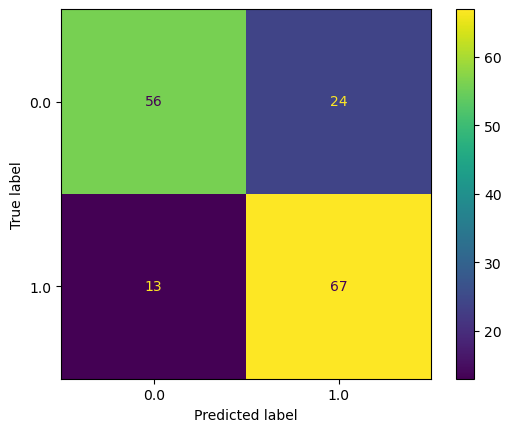

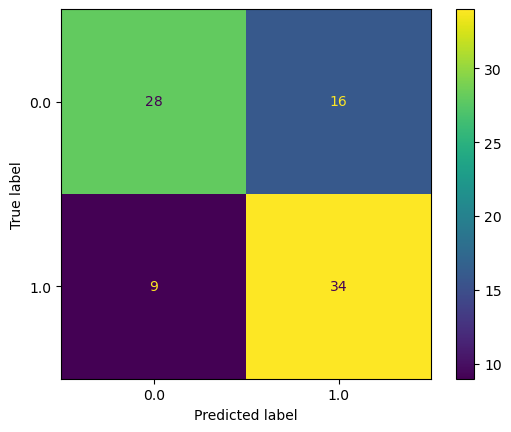

In [1027]:
#model = SVC(kernel = "linear")
#model = SVC(kernel = "poly", degree=2)
#model = LogisticRegression(max_iter = 100000)
model = SVC(kernel = "rbf")
compute_errors(model.fit(X_train, y_train), X_train, y_train, X_test, y_test)
plot_confusion_matrix(model,X_train,y_train)
plot_confusion_matrix(model,X_test,y_test)